In [1]:
import sys
import numpy as np
import pandas as pd
import os
sys.path.append(os.path.abspath('..'))
from pipeline_test_lightgbm import get_train_val_test_scaled
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_train, X_val, X_test, y_train, y_val, y_test, cat_cols = get_train_val_test_scaled()

c:\Users\jmlar\OneDrive\Documentos\GitHub\ML_group_project\pipeline_test_lightgbm.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db['odds_hw'] = db[home_win_cols].mean(axis=1)
c:\Users\jmlar\OneDrive\Documentos\GitHub\ML_group_project\pipeline_test_lightgbm.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db['odds_d']  = db[draw_cols].mean(axis=1)
c:\Users\jmlar\OneDrive\Documentos\GitHub\ML_group_project\pipeline_test_lightgbm.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [2]:
# Train models separately for home and away goals
model_home = LGBMRegressor(random_state=42)
model_away = LGBMRegressor(random_state=42)

model_home.fit(X_train, y_train['FTHG'], categorical_feature=cat_cols)
model_away.fit(X_train, y_train['FTAG'], categorical_feature=cat_cols)

c:\Users\jmlar\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jmlar\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\jmlar\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jmlar\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7160
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 90
[LightGBM] [Info] Start training from score 1.555453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7160
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 90
[LightGBM] [Info] Start training from score 1.312693


LGBMRegressor(random_state=42)

In [3]:
# Predictions
y_val_pred_home = model_home.predict(X_val)
y_val_pred_away = model_away.predict(X_val)
y_test_pred_home = model_home.predict(X_test)
y_test_pred_away = model_away.predict(X_test)

# Metrics function
def print_metrics(y_true_home, y_pred_home, y_true_away, y_pred_away, prefix=""):
    print(f"{prefix} Home Goals - MSE: {mean_squared_error(y_true_home, y_pred_home):.4f}, R²: {r2_score(y_true_home, y_pred_home):.4f}")
    print(f"{prefix} Away Goals - MSE: {mean_squared_error(y_true_away, y_pred_away):.4f}, R²: {r2_score(y_true_away, y_pred_away):.4f}")

print_metrics(y_val['FTHG'], y_val_pred_home, y_val['FTAG'], y_val_pred_away, prefix="Validation Metrics:")
print_metrics(y_test['FTHG'], y_test_pred_home, y_test['FTAG'], y_test_pred_away, prefix="Test Metrics:")

Validation Metrics: Home Goals - MSE: 0.1138, R²: 0.9116
Validation Metrics: Away Goals - MSE: 0.0885, R²: 0.9088
Test Metrics: Home Goals - MSE: 0.2415, R²: 0.8821
Test Metrics: Away Goals - MSE: 0.1964, R²: 0.7812


In [4]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Define time series cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define model
model_home = LGBMRegressor(random_state=42)

# Define parameter grid (you can add more)
param_dist = {
    'num_leaves': [31, 50, 70, 100],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Use negative MSE as scoring (lower is better)
def mse_scorer(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)

scorer = make_scorer(mse_scorer)

# Setup randomized search
random_search = RandomizedSearchCV(
    estimator=model_home,
    param_distributions=param_dist,
    n_iter=30,           # number of parameter settings to try
    scoring=scorer,
    cv=tscv,  # time series cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train['FTHG'], categorical_feature=cat_cols)

print("Best params:", random_search.best_params_)
print("Best score (neg MSE):", random_search.best_score_)

# Use best model for predictions
best_model_home = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7160
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 90
[LightGBM] [Info] Start training from score 1.555453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best params: {'subsample': 0.8, 'num_leaves': 70, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best score (neg MSE): -0.7538340892782147


In [5]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define time series cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define model
model_away = LGBMRegressor(random_state=42)

# Parameter distribution (same as for home, adjust if you want)
param_dist = {
    'num_leaves': [31, 50, 70, 100],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Negative MSE scorer (to minimize MSE)
def mse_scorer(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)

scorer = make_scorer(mse_scorer)

# Randomized search setup
random_search_away = RandomizedSearchCV(
    estimator=model_away,
    param_distributions=param_dist,
    n_iter=30,
    scoring=scorer,
    cv=tscv, # time series cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data for away goals
random_search_away.fit(X_train, y_train['FTAG'], categorical_feature=cat_cols)

print("Best params (away):", random_search_away.best_params_)
print("Best score (neg MSE, away):", random_search_away.best_score_)

# Best model for away goals
best_model_away = random_search_away.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7160
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 90
[LightGBM] [Info] Start training from score 1.312693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best params (away): {'subsample': 0.8, 'num_leaves': 70, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best score (neg MSE, away): -0.6715337163135705


In [6]:
# Best params from tuning
best_params_home = {
    'subsample': 0.8,
    'num_leaves': 50, #Different from the best params as best results came from 50 num_leaves
    'n_estimators': 500,
    'min_child_samples': 30,
    'max_depth': 20,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8,
    'random_state': 42
}

best_params_away = {
    'subsample': 0.8,
    'num_leaves': 60, #Different from the best params as best results came from 60 num_leaves
    'n_estimators': 500,
    'min_child_samples': 30,
    'max_depth': 20,
    'learning_rate': 0.01,
    'colsample_bytree': 1.0,
    'random_state': 42
}

# Initialize models
model_home = LGBMRegressor(**best_params_home)
model_away = LGBMRegressor(**best_params_away)

# Fit models
model_home.fit(X_train, y_train['FTHG'], categorical_feature=cat_cols)
model_away.fit(X_train, y_train['FTAG'], categorical_feature=cat_cols)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7160
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 90
[LightGBM] [Info] Start training from score 1.555453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7160
[LightGBM] [Info] Number of data points in the train set: 3246, number of used features: 90
[LightGBM] [Info] Start training from score 1.312693


LGBMRegressor(learning_rate=0.01, max_depth=20, min_child_samples=30,
              n_estimators=500, num_leaves=60, random_state=42, subsample=0.8)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predictions
y_val_pred_home = model_home.predict(X_val)
y_val_pred_away = model_away.predict(X_val)
y_test_pred_home = model_home.predict(X_test)
y_test_pred_away = model_away.predict(X_test)

# Metrics function with MAE
def print_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")

print("Validation Metrics:")
print_metrics(y_val['FTHG'], y_val_pred_home, "Home Goals")
print_metrics(y_val['FTAG'], y_val_pred_away, "Away Goals")

print("\nTest Metrics:")
print_metrics(y_test['FTHG'], y_test_pred_home, "Home Goals")
print_metrics(y_test['FTAG'], y_test_pred_away, "Away Goals")

# Sample predictions dataframe
sample_df = pd.DataFrame({
    'Actual_FTHG': y_test['FTHG'],
    'Pred_FTHG': y_test_pred_home,
    'Actual_FTAG': y_test['FTAG'],
    'Pred_FTAG': y_test_pred_away
}).head(10)

print("\nSample Predictions on Test Set:")
print(sample_df)


Validation Metrics:
Home Goals - MSE: 0.1626, R²: 0.8736, MAE: 0.3352
Away Goals - MSE: 0.1237, R²: 0.8725, MAE: 0.2747

Test Metrics:
Home Goals - MSE: 0.2394, R²: 0.8831, MAE: 0.3927
Away Goals - MSE: 0.2185, R²: 0.7566, MAE: 0.3615

Sample Predictions on Test Set:
      Actual_FTHG  Pred_FTHG  Actual_FTAG  Pred_FTAG
3296            2   2.227813            2   2.009210
3297            0   0.491433            1   1.020999
3298            0   0.214282            3   2.211688
3299            1   0.870345            1   0.631269
3300            2   1.952398            2   2.313771
3301            2   2.321765            1   0.930714
3302            4   3.190860            2   1.527408
3303            4   2.890092            1   1.504472
3304            1   1.159165            0   0.643290
3305            5   4.410236            0   0.497444


In [9]:
# 1) Get predictions
pred_home = model_home.predict(X_test)
pred_away = model_away.predict(X_test)
y_pred = np.column_stack([pred_home, pred_away])

# 2) True values
y_true = y_test[['FTHG', 'FTAG']].values

# 3) Individual metrics
mse_home = mean_squared_error(y_true[:, 0], y_pred[:, 0])
mse_away = mean_squared_error(y_true[:, 1], y_pred[:, 1])
r2_home = r2_score(y_true[:, 0], y_pred[:, 0])
r2_away = r2_score(y_true[:, 1], y_pred[:, 1])
mae_home = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
mae_away = mean_absolute_error(y_true[:, 1], y_pred[:, 1])

# 4) Combined (averaged) metrics
mse_combined = np.mean([mse_home, mse_away])
r2_combined = np.mean([r2_home, r2_away])
mae_combined = np.mean([mae_home, mae_away])

# 5) Print results
print(f"Home MSE: {mse_home:.4f}, Away MSE: {mse_away:.4f}, Combined MSE: {mse_combined:.4f}")
print(f"Home R²:  {r2_home:.4f}, Away R²:  {r2_away:.4f},  Combined R²:  {r2_combined:.4f}")
print(f"Home MAE: {mae_home:.4f}, Away MAE: {mae_away:.4f}, Combined MAE: {mae_combined:.4f}")


Home MSE: 0.2394, Away MSE: 0.2185, Combined MSE: 0.2290
Home R²:  0.8831, Away R²:  0.7566,  Combined R²:  0.8198
Home MAE: 0.3927, Away MAE: 0.3615, Combined MAE: 0.3771


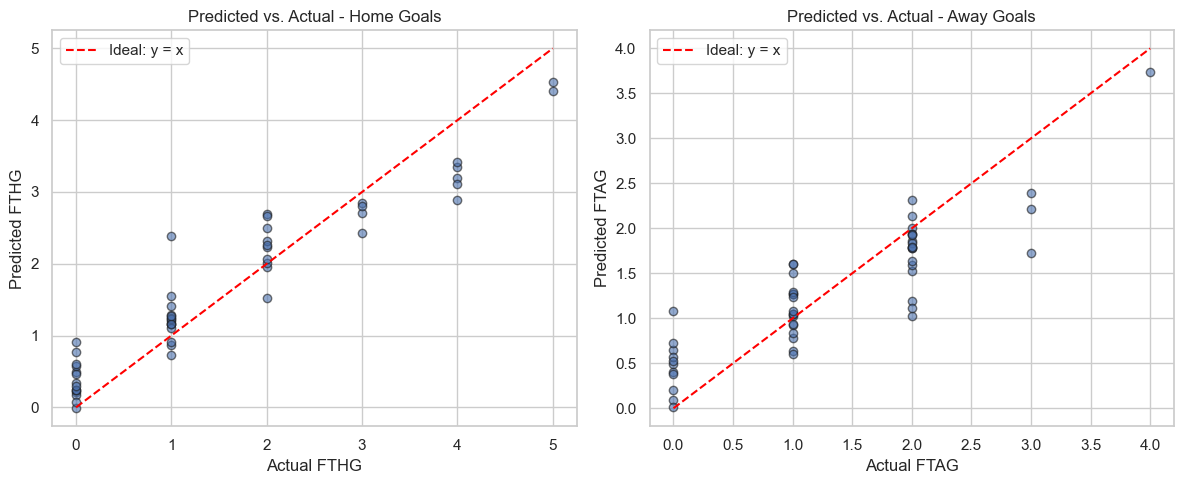

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot for FTHG (Home Goals)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test['FTHG'], y_test_pred_home, alpha=0.6, edgecolors='k')
plt.plot([y_test['FTHG'].min(), y_test['FTHG'].max()],
         [y_test['FTHG'].min(), y_test['FTHG'].max()],
         color='red', linestyle='--', label='Ideal: y = x')
plt.xlabel("Actual FTHG")
plt.ylabel("Predicted FTHG")
plt.title("Predicted vs. Actual - Home Goals")
plt.legend()
plt.grid(True)

# Plot for FTAG (Away Goals)
plt.subplot(1, 2, 2)
plt.scatter(y_test['FTAG'], y_test_pred_away, alpha=0.6, edgecolors='k')
plt.plot([y_test['FTAG'].min(), y_test['FTAG'].max()],
         [y_test['FTAG'].min(), y_test['FTAG'].max()],
         color='red', linestyle='--', label='Ideal: y = x')
plt.xlabel("Actual FTAG")
plt.ylabel("Predicted FTAG")
plt.title("Predicted vs. Actual - Away Goals")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


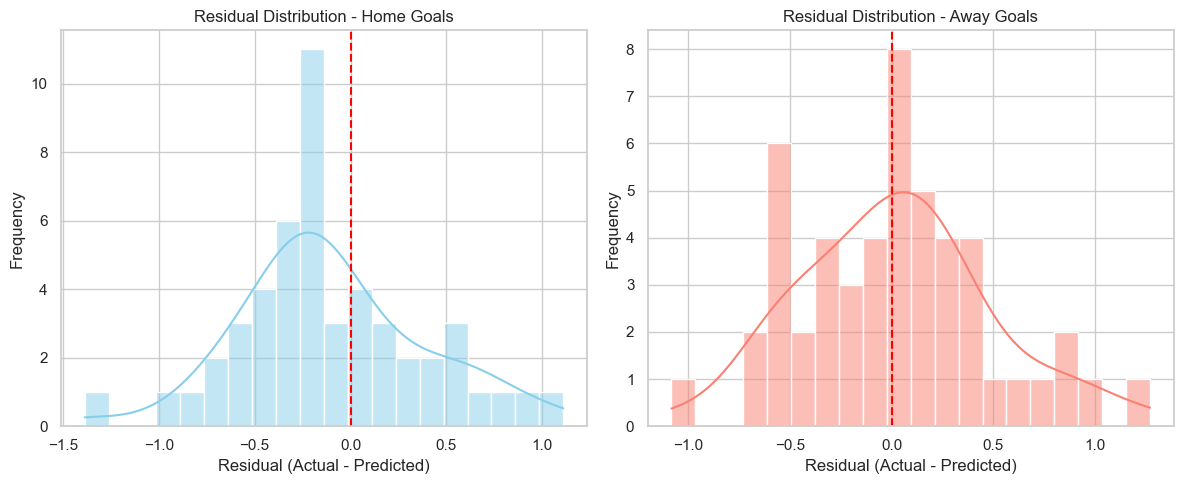

In [11]:
# Calculate residuals
residuals_home = y_test['FTHG'] - y_test_pred_home
residuals_away = y_test['FTAG'] - y_test_pred_away

# Plot histogram of residuals
plt.figure(figsize=(12, 5))

# Home Goals Residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals_home, bins=20, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution - Home Goals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")

# Away Goals Residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals_away, bins=20, kde=True, color='salmon')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution - Away Goals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [12]:
# Define KFold
tscv = TimeSeriesSplit(n_splits=5)

# Storage for metrics
mse_home, mae_home, r2_home = [], [], []
mse_away, mae_away, r2_away = [], [], []

# Use only training data for cross-validation
X = X_train.reset_index(drop=True)
y_ = y_train.reset_index(drop=True)

# Convert targets
y_home = y_[["FTHG"]].values.ravel()
y_away = y_[["FTAG"]].values.ravel()

# Loop through folds
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_home, y_val_home = y_home[train_index], y_home[val_index]
    y_train_away, y_val_away = y_away[train_index], y_away[val_index]
    
    # Train models
    model_home = LGBMRegressor(random_state=42)
    model_away = LGBMRegressor(random_state=42)
    model_home.fit(X_train, y_train_home)
    model_away.fit(X_train, y_train_away)
    
    # Predictions
    pred_home = model_home.predict(X_val)
    pred_away = model_away.predict(X_val)
    
    # Metrics
    mse_home.append(mean_squared_error(y_val_home, pred_home))
    mae_home.append(mean_absolute_error(y_val_home, pred_home))
    r2_home.append(r2_score(y_val_home, pred_home))

    mse_away.append(mean_squared_error(y_val_away, pred_away))
    mae_away.append(mean_absolute_error(y_val_away, pred_away))
    r2_away.append(r2_score(y_val_away, pred_away))

# Report average metrics
print("🏠 Home Goals CV Results:")
print(f"Avg R²: {np.mean(r2_home):.4f}, Avg MSE: {np.mean(mse_home):.4f}, Avg MAE: {np.mean(mae_home):.4f}")

print("\n🛫 Away Goals CV Results:")
print(f"Avg R²: {np.mean(r2_away):.4f}, Avg MSE: {np.mean(mse_away):.4f}, Avg MAE: {np.mean(mae_away):.4f}")

# Optionally compute combined metrics
combined_mse = np.mean([np.mean(mse_home), np.mean(mse_away)])
combined_mae = np.mean([np.mean(mae_home), np.mean(mae_away)])
combined_r2 = np.mean([np.mean(r2_home), np.mean(r2_away)])

print("\n📊 Combined Metrics:")
print(f"Avg R²: {combined_r2:.4f}, Avg MSE: {combined_mse:.4f}, Avg MAE: {combined_mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 541, number of used features: 41
[LightGBM] [Info] Start training from score 1.528651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

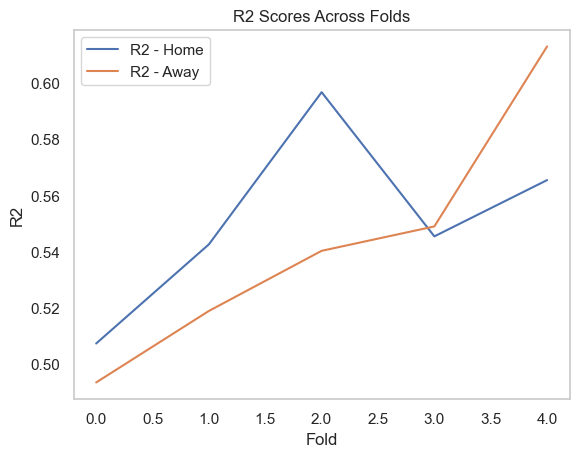

In [14]:
import matplotlib.pyplot as plt

plt.plot(r2_home, label='R2 - Home')
plt.plot(r2_away, label='R2 - Away')
plt.title('R2 Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('R2')
plt.legend()
plt.grid()
plt.show()
